![Banner challenge](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/banner1TelecomX_readme.png)


##📌 Bibliotecas.

In [231]:
%%capture
!pip install -U plotly kaleido

In [232]:
import pandas as pd
import requests
from pandas import json_normalize
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
##Para utilizar imagen de repositorio.
import urllib.request
from PIL import Image


---

#💾  **Extracción de Datos.**



![imagen banner extracción de datos](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/Banner%20Extracci%C3%B3n%20de%20datos.png)

In [233]:
url = "https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [234]:
!pip install mplcursors

---
#🧰 **Transformación.**

![Banner sección transformación](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/Banner%20transformacion%20de%20datos.png)

##📌 **Diccionario de Datos.**


*   customerID: número de identificación único de cada cliente
*   Churn: si el cliente dejó o no la empresa
*   gender: género (masculino y femenino)
*   SeniorCitizen: información sobre si un cliente tiene 65 años o más
*   Partner: si el cliente tiene pareja o no
*   Dependents: si el cliente tiene dependientes o no
*   tenure: meses de contrato del cliente
*   PhoneService: suscripción de servicio telefónico
*   MultipleLines: suscripción a más de una línea de teléfono
*   InternetService: suscripción a un proveedor de internet
*   OnlineSecurity: suscripción adicional de seguridad online
*   OnlineBackup: suscripción adicional de backup online
*   DeviceProtection: suscripción adicional de protección en el dispositivo
*   TechSupport: suscripción adicional de soporte técnico, menos tiempo de espera
*   StreamingTV: suscripción de TV por cable
*   StreamingMovies: suscripción de streaming de películas
*   Contract: tipo de contrato
*   PaperlessBilling: si el cliente prefiere recibir la factura online
*   PaymentMethod: forma de pago
*   Charges.Monthly: total de todos los servicios del cliente por mes
*   Charges.Total: total gastado por el cliente

##🛠️ **Normalización de Columnas.**

In [235]:
df_telecomX_normalizado = pd.json_normalize(data)
df_telecomX_normalizado.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


##🛠️ **Identificación de Inconsistencias en Datos.**

In [236]:
# Código para Verificación de Valores Únicos por Columna.
print(f"📝Resumen para Verificación de Valores Únicos por Columna.\n")
for col in df_telecomX_normalizado.columns:
  print(f"🟣 Columna: '{col}': {df_telecomX_normalizado[col].nunique()}\n")

  if df_telecomX_normalizado[col].nunique() < 50: # Imprima los valores solamente si no hay muchos
    print(f"\t✏️ valores = {df_telecomX_normalizado[col].unique()}\n")
  print('-' * 50)  # Línea divisoria para mejor visualización

📝Resumen para Verificación de Valores Únicos por Columna.

🟣 Columna: 'customerID': 7267

--------------------------------------------------
🟣 Columna: 'Churn': 3

	✏️ valores = ['No' 'Yes' '']

--------------------------------------------------
🟣 Columna: 'customer.gender': 2

	✏️ valores = ['Female' 'Male']

--------------------------------------------------
🟣 Columna: 'customer.SeniorCitizen': 2

	✏️ valores = [0 1]

--------------------------------------------------
🟣 Columna: 'customer.Partner': 2

	✏️ valores = ['Yes' 'No']

--------------------------------------------------
🟣 Columna: 'customer.Dependents': 2

	✏️ valores = ['Yes' 'No']

--------------------------------------------------
🟣 Columna: 'customer.tenure': 73

--------------------------------------------------
🟣 Columna: 'phone.PhoneService': 2

	✏️ valores = ['Yes' 'No']

--------------------------------------------------
🟣 Columna: 'phone.MultipleLines': 3

	✏️ valores = ['No' 'Yes' 'No phone service']

------------

In [237]:
# Verificando si hay duplicados
print(f"📝 Resumen de Verificación de Datos duplicados y Núlos.\n")
duplicados = df_telecomX_normalizado.duplicated().sum()
print(f"🟣 Número de líneas duplicadas:\n")

if  duplicados:
    print(f"\t🔸{duplicados}")
else:
    print("   ✅ No hay registros duplicados.")


# Verificando si hay valores Nulos
valores_nulos = df_telecomX_normalizado.isnull().sum()
valores_nulos.name = 'Valores Nulos'
valores_nulos_filtrados = valores_nulos[valores_nulos > 0]

print(f"\n🟣 Valores nulos por columna:\n")
if not valores_nulos_filtrados.empty:
    for columna, cantidad in valores_nulos_filtrados.items():
        print(f"\t🔸 {columna}: {cantidad}")
else:
    print("   ✅ No hay columnas con datos nulos.\n")
    display(valores_nulos)


📝 Resumen de Verificación de Datos duplicados y Núlos.

🟣 Número de líneas duplicadas:

   ✅ No hay registros duplicados.

🟣 Valores nulos por columna:

   ✅ No hay columnas con datos nulos.



,Valores Nulos
customerID,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [238]:
#código para calcular valores sin registro
valores_blanco_vacio = df_telecomX_normalizado.apply(lambda x: x.astype(str).str.strip() == '').sum()
valores_blanco_vacio.name = 'Registro en blanco'
print("\n📝 Resumen para Registros en Blanco por Columna.\n")
display(valores_blanco_vacio)


📝 Resumen para Registros en Blanco por Columna.



,Registro en blanco
customerID,0
Churn,224
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [239]:
df_telecomX_normalizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [240]:
#1. Columna 'SeniorCitizen'(0,1)(objet)Se puede convertir sus valores a 'Yes' o 'No'
#2. Columnas 'Contract y 'PaymentMethod' podríamos unir palabras por un guion (-) para tokenizar
#3. Columna 'PaymentMethod' remover (), reemplazar espacios por guion.
#4. Columna 'Charges.Total' convertir a tipo float64.
#5. Columnas 'Churn' ''
#6. Tratamiento preventivo para columnas tipo texto: Remover espacios al inicio y final,convertimos a minúscula, removemos valores nulos por desconocido.
#7. Tratamiento preventivo para columnas con caracteres numericos y conversión tipo float64.

##🛠️ **Manejo de Inconsistencias en Datos.**

In [241]:
#Tratamiento mínimo para columnas tipo cadena de texto.
#Remover espacios al inicio y final,convertimos a minúscula, removemos valores nulos por desconocido.
df_telecomX_normalizado = df_telecomX_normalizado.apply(lambda x: x.astype(str).str.lower())

In [242]:
#Retornamos formato de id_cliente.
df_telecomX_normalizado['customerID'] = df_telecomX_normalizado['customerID'].astype(str).str.upper()

In [243]:
#Columnas 'Contract y 'PaymentMethod' podríamos unir palabras por un guion (-) para tokenizar.
#Son las columnas cuyos registros deseamos unir con un guion.
columnas_espacios = ['account.Contract','account.PaymentMethod','internet.InternetService']
for col in columnas_espacios:
  df_telecomX_normalizado[col] = df_telecomX_normalizado[col].str.replace(' ','-')

In [244]:
#Columna 'Charges.Monthly','Charges.Total' Limpieza preventiva de caracteres menos numericos y el punto.
columnas_numericas = ['account.Charges.Monthly','account.Charges.Total']
for col in columnas_numericas:
  df_telecomX_normalizado[col] = pd.to_numeric(df_telecomX_normalizado[col].astype(str).str.replace(r'[^0-9.]','', regex=True), errors='coerce')

In [245]:
# Eliminar filas vacias en columna 'Churn'
df_telecomX_limpio = df_telecomX_normalizado[df_telecomX_normalizado['Churn'].str.strip() != ''].copy()
df_telecomX_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   object 
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   object 
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   object 
 1

In [246]:
# Vacíos o en blanco
conteo_vacios = df_telecomX_limpio.apply(lambda x: x.astype(str).str.strip() == '').sum()

###🛠️ **Cuentas Diarias.**

In [247]:
#Creo columna Cuentas_diarias.
df_telecomX_limpio['Cuentas_diarias'] = df_telecomX_limpio['account.Charges.Monthly']/30
df_telecomX_limpio['Cuentas_diarias']

,Cuentas_diarias
0,2.186667
1,1.996667
2,2.463333
3,3.266667
4,2.796667
...,...
7262,1.838333
7263,2.836667
7264,1.676667
7265,2.261667


In [248]:
columna_chargesM_cuenta_diaria = df_telecomX_limpio[['account.Charges.Monthly','Cuentas_diarias']].isna().sum()
print(columna_chargesM_cuenta_diaria)


account.Charges.Monthly    0
Cuentas_diarias            0
dtype: int64


###🛠️ **Estandarización y Transformación de Datos.**

####🔨 **Para Análisis Exploratorio.**

In [249]:
#Traducción de columnas.
df_telecomX_limpio.columns = ['id_cliente','evasion','genero','a_mayor','pareja','dependientes','antiguedad','telefonia',
              'multilinea','internet','seguridad','respaldo','proteccion','soporte','tv','peliculas','contrato',
              'factura_online','m_pago','cargo_mensual','cargo_total','cuenta_diaria']


In [250]:
#Transformamos valores binarios solo para análisis exploratorio.
df_telecomX_limpio['a_mayor'] = df_telecomX_limpio['a_mayor'].replace({'1':'si','0':'no'})
df_telecomX_limpio['a_mayor']

,a_mayor
0,no
1,no
2,no
3,si
4,si
...,...
7262,no
7263,no
7264,no
7265,no


In [251]:
#Traduccion de texto al español.
columnas_datos_si_internet= ['evasion','pareja','dependientes','telefonia','multilinea','internet','seguridad','respaldo','proteccion','soporte','tv','peliculas','factura_online']
for col in columnas_datos_si_internet:
  df_telecomX_limpio[col] = df_telecomX_limpio[col].replace({'yes':'si','No internet service':'no-aplica'})

#Traduccion en columna contrato.
df_telecomX_limpio['contrato'] = df_telecomX_limpio['contrato'].replace({'one-year':'anual','month-to-month':'mensual','two-year':'bianual'})
#Traduccion en columna m_pago.
df_telecomX_limpio['m_pago'] = df_telecomX_limpio['m_pago'].replace({'mailed-check':'cheque-por-correo','electronic-check':'cheque-electronico','credit-card-(automatic)':'cargo-automatico-tc',
                                                                  'bank-transfer-(automatic)':'cargo-automatico-cta-bancaria'})

In [252]:
display(df_telecomX_limpio.head(2))

,id_cliente,evasion,genero,a_mayor,pareja,dependientes,antiguedad,telefonia,multilinea,internet,...,proteccion,soporte,tv,peliculas,contrato,factura_online,m_pago,cargo_mensual,cargo_total,cuenta_diaria
0,0002-ORFBO,no,female,no,si,si,9,si,no,dsl,...,no,si,si,no,anual,si,cheque-por-correo,65.6,593.3,2.186667
1,0003-MKNFE,no,male,no,no,no,9,si,si,dsl,...,no,no,no,si,mensual,no,cheque-por-correo,59.9,542.4,1.996667


####🔧 **Para Modelado.**

In [253]:
"""
#Cambio a datos binarios.
col_dato_binario = ['desersion','pareja','dependientes','telefonia','factura_online']
for col in col_dato_binario:
  df_telecomX_limpio[col] = df_telecomX_limpio[col].replace({'yes': 1, 'no': 0}).astype('int64')

  print(f"✅ {df_telecomX_limpio[col].value_counts(dropna=False)}\n")
"""
print()

---

#📊 **Carga y análisis.**

![Banner sección carga y análisis](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/banner%20carga%20y%20an%C3%A1lisis.png)

✏️ **Análisis Descriptivo.**
--

* Hay 11 registros en cargo_total que no aparecen en las otras columnas.

* Se recomienda verificar de qué manera puede recalcularse el valor de esos registros faltantes. Por ejemplo, si el contrato es mensual, es posible que el cargo_total coincida con el cargo_mensual.

In [254]:
display(df_telecomX_limpio.describe())

,cargo_mensual,cargo_total,cuenta_diaria
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,2.158723
std,30.090047,2266.771362,1.003002
min,18.250000,18.800000,0.608333
25%,35.500000,401.450000,1.183333
50%,70.350000,1397.475000,2.345000
75%,89.850000,3794.737500,2.995000
max,118.750000,8684.800000,3.958333


🟣 **Interpretar la Distribución.**

* Si mean ≈ 50%, podrías estar frente a una distribución simétrica.

* Si mean > 50%, distribución sesgada a la izquierda (cola larga hacia la izquierda).

* Si mean < 50%, distribución sesgada a la derecha (cola larga hacia la derecha).

🟣 **Rango y dispersión.**

* max - min: te da el rango total de valores.

* std: cuanto mayor sea, más dispersos están los datos respecto al promedio.

* Si std es muy grande respecto a la mean, indica alta variabilidad.

🟣 Cuartiles.

* Puedes ver la concentración de los datos:

* Si Q3 - Q1 (llamado rango intercuartílico) es pequeño: los datos están más concentrados.

* Si es grande: hay alta dispersión entre el 25% y el 75% central de los datos.

**Escala de Apreciación del Coeficiente de Variación.**


| CV (%)        | Nivel de dispersión | Descripción sugerida                                            |
| ------------- | ------------------- | --------------------------------------------------------------- |
| **0% – 15%**  | Muy baja dispersión | Los datos son altamente homogéneos. Muy poca variación.         |
| **15% – 30%** | Baja dispersión     | Los datos son bastante consistentes. Variación limitada.        |
| **30% – 50%** | Moderada dispersión | Hay diferencias visibles entre los valores.                     |
| **50% – 70%** | Alta dispersión     | Alta variabilidad. Los valores están bastante separados.        |
| **> 70%**     | Muy alta o extrema  | Dispersión muy marcada. El promedio deja de ser representativo. |


#####🏷️ **Interpretación.**

* **Variable antiguedad.**
  El promedio es de 32.37 meses, la mediana es de 29 meses y la desviación estándar es 24.55 meses.

  Esto sugiere una asimetría positiva leve, donde algunos valores altos podrían estar elevando la media.

  EL coeficiente de variación (CV) es de 75.84%, lo que indica una dispersión muy alta.
  
  Interpretación: La variabilidad en la antigüedad de los clientes es tan marcada que el promedio deja de ser un valor representativo del conjunto.

* **Variable cargo_mensual.**

  El promedio es de \$64.76, la mediana es \$70.35 y la desviación estándar es \$30.09.

  Esto sugiere una asimetría negativa leve, donde algunos valores pequeños podrían estar reduciendo la media.

  El coeficiente de variación (CV) es de 46.46%, lo que indica una dispersión moderadamente alta.
  
  Interpretación: los cargos mensuales varían considerablemente entre clientes.


* **Variable cargo_total.**

  El promedio es de $2,279.73, la mediana es \$1,394.55 y la desviación estándar es \$2,266.79.

  La diferencia notable entre la media y la mediana sugiere una asimetría positiva alta, donde algunos valores extremos elevan el promedio.

  El CV es de 99.43%, lo que indica una alta dispersión.
  
  Interpretación: el total acumulado que pagan los clientes varía ampliamente entre usuarios.

* **Variable cuenta_diaria.**

  El promedio diario es de \$2.16 , la mediana  \$2.35, y la desviación estándar es \$1.00.

  La diferencia sutil entre la media y la mediana sugiere una asimetría negativa muy leve, donde algunos valores bajos pueden estar ligeramente reduciendo la media.

  El CV es de 46.30%, lo que también indica una dispersión moderadamente alta.
  
  Interpretación: los cargos diarios no son uniformes y varían de forma significativa entre clientes.

#####🏷️**Gráfico Boxplot.**

In [255]:
#Cambio de dato object a numeric en columna antiguedad.
df_telecomX_limpio['antiguedad'] = pd.to_numeric(df_telecomX_limpio['antiguedad'],errors='coerce')
# Calcular el cargo_total donde falta.
# Calcular cargo_total donde falte usando antigüedad en meses (convertida a días) y cuenta_diaria
df_telecomX_limpio['cargo_total'] = df_telecomX_limpio.apply(
    lambda row: (row['antiguedad'] * 30) * row['cuenta_diaria'] if pd.isnull(row['cargo_total']) else row['cargo_total'],
    axis=1
)

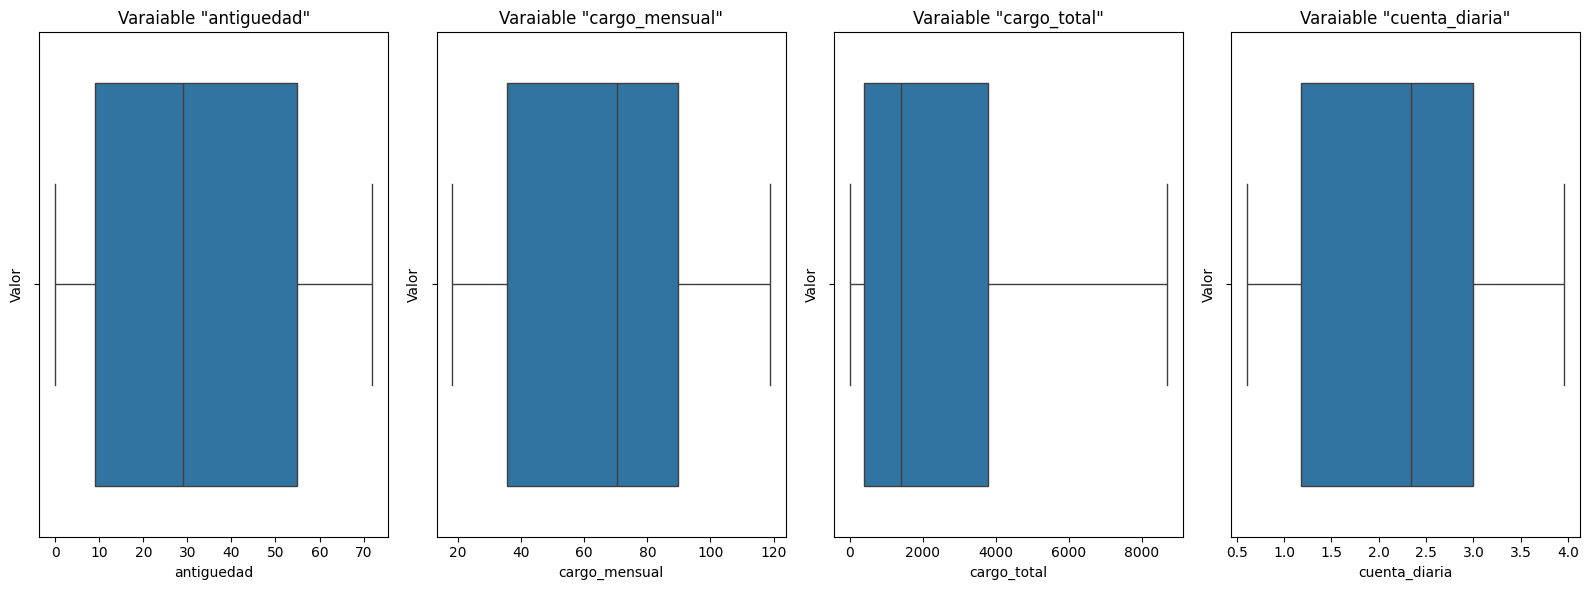

In [256]:
import mplcursors

#Código para boxplot.

# Supongamos que df es tu DataFrame y tienes las columnas 'var1', 'var2', 'var3', 'var4'
# que quieres graficar como boxplots

# Lista de las columnas que contienen los valores numéricos
variables = ['antiguedad', 'cargo_mensual', 'cargo_total', 'cuenta_diaria']

# Crear un lienzo con 4 subgráficos (1 columna, 4 filas)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))

# Itera sobre las columnas y genera un boxplot para cada una
for i, var in enumerate(variables):
    sns.boxplot(x=df_telecomX_limpio[var], ax=axes[i])
    axes[i].set_title(f'Varaiable "{var}"')
    axes[i].set_ylabel('Valor')

    # Agregar interactividad para mostrar los datos al pasar el cursor
    mplcursors.cursor(axes[i], hover=True)

# Ajustar el layout para que los gráficos no se sobrepongan
plt.tight_layout()

# Guardar la figura .
plt.savefig("boxplot_variables_numericas.png", dpi=300, bbox_inches='tight')

# Mostrar los gráficos
plt.show()


##🔍 **Análisis Exploratoria (EDA).**

#####🏷️**Variable evasion.**

In [257]:

#Código para distribución de frecuencia.
variables_categóricas = ['evasion', 'genero', 'a_mayor', 'pareja',
       'dependientes','telefonia', 'multilinea', 'internet',
       'seguridad', 'respaldo', 'proteccion', 'soporte', 'tv', 'peliculas',
       'contrato', 'factura_online', 'm_pago','cargo_total']

#Contiene la distribución de frecuencia de cada variable categórica.
frecuencia_variable_categorica = {}

for col in variables_categóricas:
  frecuencia = df_telecomX_limpio[col].value_counts()
  participacion = df_telecomX_limpio[col].value_counts(normalize=True)  # para ver % participación
  frecuencia_variable_categorica[col] = pd.concat([frecuencia,participacion],axis=1)


In [258]:
#Código  para calcular distribución de frecuencia absoluta y relativa para la columna evasión.
print(f"🔢 Distribución de Frecuencia Absoluta y Relativa para Variable 'Evasion'.\n")
df_telecomX_limpio['evasion'].astype(str).str.replace('yes','si',regex=True)

frecuencia_variable_categorica['evasion'].columns = ['Absoluta','Relativa']
v_desersion = frecuencia_variable_categorica['evasion']
display(v_desersion)



🔢 Distribución de Frecuencia Absoluta y Relativa para Variable 'Evasion'.



,Absoluta,Relativa
evasion,,
no,5174,0.73463
si,1869,0.26537


In [259]:
# Reemplazar 'yes' por 'si' en la columna 'evasion' (si es necesario)
df_telecomX_limpio['evasion'] = df_telecomX_limpio['evasion'].astype(str).str.replace('yes', 'si', regex=True)


# Crear gráfico de barras con Plotly usando los datos de v_desersion
fig = go.Figure()

# Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
    x=v_desersion.index,  # Usar el índice como las categorías de 'evasion'
    y=v_desersion['Absoluta'],  # Usar la frecuencia absoluta de v_desersion
    marker_color=['green', 'blue'],  # Colores para las categorías
))

# Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
    title="Frecuencia Absoluta Variable 'Evasion'.",
    xaxis_title='Categorías de Evasión',
    yaxis_title='Frecuencia Absoluta',
    bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
    width=800,   # Ajustar el tamaño de la figura
    height=400,  # Ajustar la altura
    xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
)


#Guardar imagen interactiva.
fig.write_html("grafico_evasion.html", include_plotlyjs="cdn")

# Mostrar el gráfico
fig.show()


#####🏷️**Variables Numéricas.**

###### **Distribución de Frecuencia.**

In [260]:
##Recalculando datos en columna cargo_total.
df_telecomX_limpio.columns

Index(['id_cliente', 'evasion', 'genero', 'a_mayor', 'pareja', 'dependientes',
       'antiguedad', 'telefonia', 'multilinea', 'internet', 'seguridad',
       'respaldo', 'proteccion', 'soporte', 'tv', 'peliculas', 'contrato',
       'factura_online', 'm_pago', 'cargo_mensual', 'cargo_total',
       'cuenta_diaria'],
      dtype='object')

In [261]:
df_telecomX_limpio['evasion'].unique()

array(['no', 'si'], dtype=object)

In [262]:
# Resumen estadístico por grupo de evasión.
df_telecomX_limpio.groupby('evasion')['antiguedad'].describe()


,count,mean,std,min,25%,50%,75%,max
evasion,,,,,,,,
no,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0
si,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


In [263]:
df_telecomX_limpio_copy = df_telecomX_limpio.copy()
df_telecomX_limpio_copy['evasion'] = df_telecomX_limpio_copy['evasion'].map({'si': 1, 'no': 0})
display(df_telecomX_limpio_copy.describe())

,evasion,antiguedad,cargo_mensual,cargo_total,cuenta_diaria
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.265370,32.371149,64.761692,2279.734304,2.158723
std,0.441561,24.559481,30.090047,2266.794470,1.003002
min,0.000000,0.000000,18.250000,0.000000,0.608333
25%,0.000000,9.000000,35.500000,398.550000,1.183333
50%,0.000000,29.000000,70.350000,1394.550000,2.345000
75%,1.000000,55.000000,89.850000,3786.600000,2.995000
max,1.000000,72.000000,118.750000,8684.800000,3.958333


In [264]:
# Resumen estadístico por grupo de evasión.
resumen = df_telecomX_limpio_copy.groupby('evasion')['antiguedad'].describe()
#Lista para variables numéricas.
variables_numericas = ['antiguedad', 'cargo_mensual', 'cargo_total', 'cuenta_diaria']


def resumen_estadistico(df, columna):
    resumen = df.groupby('evasion')[columna].describe()

    # Calcular IQR en meses y años.
    resumen['IQR'] = resumen['75%'] - resumen['25%']

    media_meses = resumen.loc[0,'mean'] - resumen.loc[1,'mean']
    media_años = media_meses / 12

    medianas_meses = resumen.loc[0,'50%'] - resumen.loc[1,'50%']

    print(f"🟡 Resumen estadístico para evasion vs {col}.\n")
    display(resumen)
    print(f"\n✏️ Diferencia de medias: {media_meses:.2f} \n")
    print(f"✏️ Diferencia de medianas: {medianas_meses:.2f} \n\n\n")


for col in variables_numericas:
  resumen_estadistico(df_telecomX_limpio_copy, col)


🟡 Resumen estadístico para evasion vs antiguedad.



,count,mean,std,min,25%,50%,75%,max,IQR
evasion,,,,,,,,,
0,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0,46.0
1,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0,27.0



✏️ Diferencia de medias: 19.59 

✏️ Diferencia de medianas: 28.00 



🟡 Resumen estadístico para evasion vs cargo_mensual.



,count,mean,std,min,25%,50%,75%,max,IQR
evasion,,,,,,,,,
0,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75,63.30
1,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35,38.05



✏️ Diferencia de medias: -13.18 

✏️ Diferencia de medianas: -15.22 



🟡 Resumen estadístico para evasion vs cargo_total.



,count,mean,std,min,25%,50%,75%,max,IQR
evasion,,,,,,,,,
0,5174.0,2549.911442,2329.954215,0.00,572.9,1679.525,4262.85,8672.45,3689.95
1,1869.0,1531.796094,1890.822994,18.85,134.5,703.550,2331.30,8684.80,2196.80



✏️ Diferencia de medias: 1018.12 

✏️ Diferencia de medianas: 975.98 



🟡 Resumen estadístico para evasion vs cuenta_diaria.



,count,mean,std,min,25%,50%,75%,max,IQR
evasion,,,,,,,,,
0,5174.0,2.042171,1.036422,0.608333,0.836667,2.1475,2.946667,3.958333,2.110000
1,1869.0,2.481378,0.822202,0.628333,1.871667,2.6550,3.140000,3.945000,1.268333



✏️ Diferencia de medias: -0.44 

✏️ Diferencia de medianas: -0.51 





######**Boxplots.**

In [265]:
#Gráfico para evasión vs  antigüedad.
# Crear un boxplot interactivo con colores personalizados
fig = px.box(df_telecomX_limpio_copy,
             x='evasion',
             y='antiguedad',
             color='evasion',
             title='Boxplot de Antigüedad por Evasión (0: No, 1: Sí)',
             labels={'evasion': 'Evasión', 'antiguedad': 'Antigüedad'},
             color_discrete_map={0: 'green', 1: 'blue'})  # Personalizar colores

# Ajustar el tamaño de la figura (más ancho y alto)
fig.update_layout(
    width=800,  # Establecer el ancho de la figura
    height=400   # Establecer la altura de la figura
)


#Guardar imagen interactiva.
fig.write_html("grafico_evasion_vs_antiguedad.html", include_plotlyjs="cdn")

# Mostrar el gráfico
fig.show()


In [266]:
#Gráfico para evasión vs cargo mensual.
# Crear un boxplot interactivo con colores personalizados
fig = px.box(df_telecomX_limpio_copy,
             x='evasion',
             y='cargo_mensual',
             color='evasion',
             title='Boxplot de Cargo Mensual por Evasión (0: No, 1: Sí)',
             labels={'evasion': 'Evasión', 'cargo_mensual': 'Cargo Mensual'},
             color_discrete_map={0: 'green', 1: 'blue'})  # Personalizar colores

# Ajustar el tamaño de la figura (más ancho y alto)
fig.update_layout(
    width=800,  # Establecer el ancho de la figura
    height=400   # Establecer la altura de la figura
)

#Guardar imagen interactiva.
fig.write_html("boxplot_evasion_vs_cargo_mensual.html", include_plotlyjs="cdn")

# Mostrar el gráfico
fig.show()


In [267]:
#Gráfico para evasión vs cargo total.
# Crear un boxplot interactivo con colores personalizados
fig = px.box(df_telecomX_limpio_copy,
             x='evasion',
             y='cargo_total',
             color='evasion',
             title='Boxplot de Cargo Total por Evasión (0: No, 1: Sí)',
             labels={'evasion': 'Evasión', 'cargo_total': 'Antigüedad'},
             color_discrete_map={0: 'green', 1: 'blue'})  # Personalizar colores

# Ajustar el tamaño de la figura (más ancho y alto)
fig.update_layout(
    width=800,  # Establecer el ancho de la figura
    height=400   # Establecer la altura de la figura
)

#Guardar imagen interactiva.
fig.write_html("boxplot_evasion_vs_cargo_total.html", include_plotlyjs="cdn")

# Mostrar el gráfico
fig.show()


In [268]:
#Gráfico para evasión vs cargo diario.
# Crear un boxplot interactivo con colores personalizados
fig = px.box(df_telecomX_limpio_copy,
             x='evasion',
             y='cuenta_diaria',
             color='evasion',
             title='Boxplot Cuenta Diaria por Evasión (0: No, 1: Sí)',
             labels={'evasion': 'Evasión', 'cuenta_diaria': 'Antigüedad'},
             color_discrete_map={0: 'green', 1: 'blue'})  # Personalizar colores

# Ajustar el tamaño de la figura (más ancho y alto)
fig.update_layout(
    width=800,  # Establecer el ancho de la figura
    height=400   # Establecer la altura de la figura
)

#Guardar imagen interactiva.
fig.write_html("boxplot_evasion_vs_cuenta_diaria.html", include_plotlyjs="cdn")


# Mostrar el gráfico
fig.show()


######**Tendencia general evasión con variables numéricas.**


* Evasion vs antiguedad.

✔️ Patrón fuerte.

  Los clientes más recientes tienen más probabilidad de evadir, mientras que los clientes con más tiempo en la compañía tienden a permanecer.

* Evasion vs cargo_mensual.

✔️  Patrón fuerte.

Los clientes que no han desertado (0) tienden a tener facturas mensuales más bajas en promedio, pero con una mayor variabilidad en los cargos. Esto podría indicar que el grupo incluye tanto a clientes con planes bajos como a algunos con planes más altos.

Los clientes que han desertado (1), por otro lado, tienden a tener facturas mensuales más altas y más homogéneas, lo que podría ser un indicio de que los clientes que pagan más por sus servicios son más propensos a desertar.

* Evasion vs cargo_total.

✔️  Patrón fuerte.

Clientes no evasores, acumulan montos elevados por la influencia del tiempo facturando en la empresa. Clientes evasores en corto tiempo han acumulado montos totales con diferencias corta  975 y siendo que solo representan el 26.53% del universo de clientes.

Las diferencias entre sus medianas refuerzan la idea que clientes que permanecen han acumulado más que los evasores por factor tiempo, pero que la diferencia acumulada no es tan grande reforzando la idea que los clientes que evaden acumulan más en menos tiempo por que pagan más.

* Evasion vs cuenta_diaria.

✔️ Patrón fuerte.

Clientes que evaden con en promedio de cargos diarios mayor a los clientes que no evaden. Afirma la hipotesis que los clientes que evaden pobablemente tienen contratos más cortos o cancelan su servicio por obtener menor valor a un mismo precio.

#####🏷️**Variables Categóricas.**

######**Distribución de Frecuencia.**

In [269]:
#código para generar crosstab.
#Lista con variables categoricas para comparar distribución con la variable evasión.

variables_categóricas = ['genero', 'a_mayor', 'pareja',
       'dependientes','telefonia', 'multilinea', 'internet',
       'seguridad', 'respaldo', 'proteccion', 'soporte', 'tv', 'peliculas',
       'contrato', 'factura_online', 'm_pago']

#Diccionario para guardar resumen de frecuencias por variables.
frecuencia_variable_categorica = {}

#Declaro función para construir crosstab.
def crosstab_churn(df, col_cat, col_target, margins_name="Total"):
    # 1) Tabla de conteos absolutos con fila y columna Total
    tabla_abs = pd.crosstab(
        df[col_cat],
        df[col_target],
        margins=True,
        margins_name=margins_name
    )

    # 2) Detectar columnas reales del target (excluir columna de totales)
    cols_target = [c for c in tabla_abs.columns if c != margins_name]

    # 3) Calcular % por fila solo para las columnas reales del target
    tabla_pct = tabla_abs[cols_target].div(
        tabla_abs[cols_target].sum(axis=1), axis=0
    ) * 100

    # 4) Agregar columnas de %
    for col in cols_target:
        tabla_abs[f"{col} (%)"] = tabla_pct[col].round(2)

    # 5) Agregar columna de verificación de suma de %
    tabla_abs["Suma %"] = tabla_abs[[f"{col} (%)" for col in cols_target]].sum(axis=1).round(2)

    return tabla_abs

for col in variables_categóricas:

  tabla = crosstab_churn(df_telecomX_limpio, col, 'evasion')
  frecuencia_variable_categorica[col] = tabla
  (f"🔢 Distribución evasion vs {col}.\n")
  display(tabla)
  print(f'\n\n')

evasion,no,si,Total,no (%),si (%),Suma %
genero,,,,,,
female,2549,939,3488,73.08,26.92,100.0
male,2625,930,3555,73.84,26.16,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
a_mayor,,,,,,
no,4508,1393,5901,76.39,23.61,100.0
si,666,476,1142,58.32,41.68,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
pareja,,,,,,
no,2441,1200,3641,67.04,32.96,100.0
si,2733,669,3402,80.34,19.66,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
dependientes,,,,,,
no,3390,1543,4933,68.72,31.28,100.0
si,1784,326,2110,84.55,15.45,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
telefonia,,,,,,
no,512,170,682,75.07,24.93,100.0
si,4662,1699,6361,73.29,26.71,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
multilinea,,,,,,
no,2541,849,3390,74.96,25.04,100.0
no phone service,512,170,682,75.07,24.93,100.0
si,2121,850,2971,71.39,28.61,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
internet,,,,,,
dsl,1962,459,2421,81.04,18.96,100.0
fiber-optic,1799,1297,3096,58.11,41.89,100.0
no,1413,113,1526,92.60,7.40,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
seguridad,,,,,,
no,2037,1461,3498,58.23,41.77,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1724,295,2019,85.39,14.61,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
respaldo,,,,,,
no,1855,1233,3088,60.07,39.93,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1906,523,2429,78.47,21.53,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
proteccion,,,,,,
no,1884,1211,3095,60.87,39.13,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1877,545,2422,77.50,22.50,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
soporte,,,,,,
no,2027,1446,3473,58.36,41.64,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1734,310,2044,84.83,15.17,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
tv,,,,,,
no,1868,942,2810,66.48,33.52,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1893,814,2707,69.93,30.07,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
peliculas,,,,,,
no,1847,938,2785,66.32,33.68,100.0
no internet service,1413,113,1526,92.60,7.40,100.0
si,1914,818,2732,70.06,29.94,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
contrato,,,,,,
anual,1307,166,1473,88.73,11.27,100.0
bianual,1647,48,1695,97.17,2.83,100.0
mensual,2220,1655,3875,57.29,42.71,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
factura_online,,,,,,
no,2403,469,2872,83.67,16.33,100.0
si,2771,1400,4171,66.43,33.57,100.0
Total,5174,1869,7043,73.46,26.54,100.0


evasion,no,si,Total,no (%),si (%),Suma %
m_pago,,,,,,
cargo-automatico-cta-bancaria,1286,258,1544,83.29,16.71,100.0
cargo-automatico-tc,1290,232,1522,84.76,15.24,100.0
cheque-electronico,1294,1071,2365,54.71,45.29,100.0
cheque-por-correo,1304,308,1612,80.89,19.11,100.0
Total,5174,1869,7043,73.46,26.54,100.0


######🔷 **Interpretación Distribución de Variables categóricas Respecto a la Variable Evasión.**


---

######🔹  **Distribución evasion vs genero.**


* Dentro de cada género:

  - Mujeres: 73.08% no evaden, 26.92% sí evaden.

  - Hombres: 73.84% no evaden, 26.16% sí evaden.

  Las tasas de evasión son muy parecidas entre géneros: la diferencia es de 0.76 puntos porcentuales (26.92% vs 26.16%).

* Género vs evasión:

  - En el grupo que " sí " evade:

  Muy parejos. La diferencia es de apenas 9 casos y 7043 clientes totales.

  - En el grupo que " no " evade:

  La diferencia es muy pequeña también.

* Total General.

 Tasa de evasión global = 26.54%. Cada género se mueve muy poco respecto a ese promedio:

 - Mujeres: +0.38 puntos.
 - Hombres: -0.38 puntos.

* Conclusión.

 ❌ El género no parece ser un factor fuerte en la evasión debido a que las proporciones son aparentemente iguales.
    
---

######🔹  **Distribución evasion vs a_mayor.**


* Clientes no adultos mayores.

  - No evaden: 76.39 %
  - Sí evaden: 23.61 %
  
  Evasión menor al promedio general 26.54%.

  Comportamiento más favorable (menos evasión).

* Clientes adultos mayores.

 - No evaden: 58.32 %
 - Sí evaden: 41.68 %

 Evasión mucho más alta. +15.14 puntos porcentuales respecto al promedio general.

* Diferencia entre adultos mayores y no mayores.
 - 41.68 % - 23.61 % = 18.07 puntos porcentuales.
 Un salto considerable que sugiere que la edad es un factor importante en la evasión.

* Conclusión.

 ✔️   Patrón claro. Los clientes adultos mayores presentan una tasa de evasión significativamente más alta. Esto amerita análisis adicional. (¿Se debe a condiciones económicas?, ¿A dificultades con el uso de los servicios? ¿Los planes no son atractivos?)

 Estadísticamente, aquí si vale la pena hacer una prueba de Chi-cuadrado porque la diferencia es fuerte y probablemente significativa.




In [270]:
df_a_mayor = pd.DataFrame(frecuencia_variable_categorica['a_mayor'])

# Crear gráfico de barras para a_mayor.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_a_mayor.index,  # Usar el índice como las categorías de 'evasion'
      y=df_a_mayor['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable adulto mayor.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Adulto Mayor',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )


#Guardar imagen interactiva.
fig.write_html("grafico_a_mayor.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

---

######🔹  **Distribución evasion vs pareja.**

* Clientes sin pareja.

 - No evaden: 67.04 %

 - Sí evaden: 32.96 %

  Evasión superior a la media global 26.54% por +6.42 puntos.

* Clientes con pareja.

  - No evaden: 80.34 %

  - Sí evaden: 19.66 %

  Evasión inferior a la media global en -6.88 puntos.

* Diferencia de evasión entre clientes sin pareja y con pareja.

  32.96 % - 19.66 % = 13.30 puntos porcentuales. Una diferencia interesante ya que sugiere que vivir en pareja se asocia a menor evasión.

* Conclusión prelimminar.

 ✔️ Patrón claro: Los clientes sin pareja tienen una tasa de evasión claramente más alta que los que tienen pareja.  


In [271]:
df_pareja = pd.DataFrame(frecuencia_variable_categorica['pareja'])

# Crear gráfico de barras para
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_pareja.index,  # Usar el índice como las categorías de 'evasion'
      y=df_pareja['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable pareja.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Pareja',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_pareja.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

---

######🔹  **Distribución evasion vs dependientes.**

* Clientes sin dependientes.

  - No evaden: 68.72 %

  - Sí evaden: 31.28 %

  Tasa de evasión +4.74 puntos porcentuales por encima de la media global.

* Clientes con dependientes.

  - No evaden: 84.55 %

  - Sí evaden: 15.45 %

  Tasa de evasión -11.09 puntos porcentuales por debajo de la media global.

* Diferencia de evasión entre sin dependientes y con dependientes.

  31.28 % - 15.45 % = 15.83 puntos porcentuales.

  Esto es una brecha importante: tener dependientes se asocia a una menor evasión.

* Conclusión preliminar.
  
 ✔️ Patrón: Los clientes sin dependientes evaden casi el doble que los que sí tienen dependientes.

In [272]:
df_dependientes = pd.DataFrame(frecuencia_variable_categorica['dependientes'])

# Crear gráfico de barras para dependientes.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_dependientes.index,  # Usar el índice como las categorías de 'evasion'
      y=df_dependientes['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable dependientes.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Dependientes',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_dependientes.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

---

######🔹**Distribución evasion vs telefonia.**


* Clientes sin telefonía.

  - No evaden: 75.07%

  - Sí evaden: 24.93%

  Evasión -1.61 punto porcentual respecto a la media global.

* Clientes con telefonía.

  - No evaden: 73.29%

  - Sí evaden: 26.71%

  Evasión +0.17 punto porcentual respecto a la media global.

* Diferencia de evasión entre sin telefonía y con telefonía:

  26.71% - 24.93% = 1.78 puntos porcentuales.

  Brecha muy pequeña el servicio de telefonía no parece tener gran relación con la evasión.

* Conclusión preliminar.
  
  Patrón: No hay diferencias relevantes en evasión respecto a si el cliente tiene o no el servicio de telefonía.

  ❌ Probablemente no es el producto en sí el que impulsa la salida, si no otros factores. Los datos que venian anidados bajo la columna " phone " son una pista para profundizar con más detalle para identificar subtipos de clientes dentro de otros servicios asociados a la telefonía que pudieran estar influyendo en su desición de avandonar el servicio.


Si “telefonía” y “internet” son productos raíz, y los demás servicios anidados son adicionales, entonces un cliente es un conjunto de productos raíz + adicionales.

Podemos reconstruir combinaciones (paquetes) usando sólo las columnas raíz o bien desglosando hasta el nivel de servicio anidado si quieres un análisis más detallado.

---

######🔹  **Distribución evasion vs multilinea.**

* Clientes con una sola línea (no).

  - Evasión: 25.04 %

  Ligeramente por debajo de la media global -1.50 puntos porcentuales.

* Clientes sin servicio de telefonía (no phone service)
  - Evasión: 24.93 %

  Muy parecida al grupo de una sola línea -1.61 pp respecto a la media global.

  Esto confirma que este grupo está fuera del servicio principal de telefonía.

* Clientes con múltiples líneas (sí).

  - Evasión: 28.61 %

  Por encima de la media global +2.07 puntos porcentuales.

  Este es el grupo con la evasión más alta dentro de la variable.

* Diferencia de evasión entre una sola línea y múltiples líneas.
  28.61 % - 25.04 % = 3.57 puntos porcentuales.

  No es una brecha enorme, pero sí sugiere que tener múltiples líneas podría asociarse a una evasión ligeramente mayor.

* Conclusión.

  ✔️  Clientes con múltiples líneas pueden ser más sensibles a precios por pagar más de un servicio.

  Podrían estar más expuestos a la competencia que ofrezca mejores tarifas por paquetes multi-línea.

  El abandono podría ocurrir por racionalización de costos: quedarse con una sola línea o migrar todo a otra compañía.



---

######🔹  **Distribución evasion vs internet.**


* Clientes con DSL.
 - Evasión: 18.96 %

  Muy por debajo de la media global -7.58 puntos porcentuales.

  Este parece ser el tipo de internet con mayor retención.

* Clientes con fibra óptica
  - Evasión: 41.89 %

  Muy por encima de la media global +15.35 puntos porcentuales.

  Es el segmento con mayor deserción de toda la variable.

* Clientes sin internet.
  - Evasión: 7.40 %

  Extremadamente por debajo de la media global -19.14 puntos porcentuales.

  Esto sugiere que este grupo es muy estable o que la contratación de otros servicios no está tan expuesta a la competencia.

- Fibra óptica vs DSL: Diferencia de 22.93 pp en evasión.

- Fibra óptica vs sin internet: Diferencia de 34.49 pp.

- Estas brechas son enormes y merecen análisis más profundo.

 - La fibra óptica suele atraer clientes que buscan altas velocidades y podrían ser más sensibles a precios o promociones de la competencia.

 - DSL, aunque tecnológicamente inferior, podría tener planes más económicos y estables que retengan mejor al cliente.

 - Quienes no tienen internet probablemente contratan solo telefonía y no sienten presión para cambiar, o son clientes de larga data en planes básicos.

* Conclusión preliminar.

  Patron: La fibra óptica presenta una tasa de evasión alarmantemente alta; DSL y la ausencia de internet retienen mucho más.

  ✔️ Esto podría indicar problemas de satisfacción en clientes de fibra óptica o una mayor agresividad competitiva en este segmento.

In [273]:
df_internet = pd.DataFrame(frecuencia_variable_categorica['internet'])

# Crear gráfico de barras para internet.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_internet.index,  # Usar el índice como las categorías de 'evasion'
      y=df_internet['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF4F79', '#FF7F00','#8B4513'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable internet.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Internet',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_internet.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs seguridad.**

* Clientes con internet pero sin seguridad en línea (no)

 - Evasión: 41.77%

  Muy por encima de la media global +15.23 puntos porcentuales.

  Claramente es un grupo con alta propensión a desertar.

* Clientes con seguridad en línea (sí)
  - Evasión: 14.61 %

  Por debajo de la media global en  -11.93 puntos porcentuales.

  Este menor nivel de evasión probablemente se relacione con que muchos clientes pertenecen a planes antiguos o más completos que incluyen este servicio, y que resultan más atractivos o competitivos frente a la oferta actual del mercado. O por comodidad.


* Clientes sin servicio de internet (no internet service)

  - Evasión: 7.40 %

  Extremadamente por debajo de la media global -19.14 puntos porcentuales.

  Grupo estable, similar a lo que vimos en el bloque 7.

* Con vs sin seguridad en línea (entre clientes con internet):
  - Diferencia de 27.16 puntos porcentuales en evasión (14.61% vs 41.77%).

  Esta diferencia es considerable, pero no necesariamente se debe al servicio en sí, sino posiblemente a que los clientes con seguridad en línea pertenecen a planes antiguos o más completos, mientras que quienes no lo tienen podrían estar en planes más caros o menos competitivos, lo que los hace más propensos a migrar a la competencia.

  Esto implica que el servicio de seguridad podría ser un marcador indirecto de antiguedad y estructura del plan, no necesariamente el motivo directo de la retención.

* Conclusión preliminar.

  🟢 Patrón claro: Entre los clientes con internet, los que tienen el servicio de seguridad presentan una tasa de evasión mucho menor (14.61% vs 41.77%).

  🟢 Sin embargo, esto probablemente refleja diferencias en el tipo de plan contratado y no sólo la presencia del servicio en sí: planes más antiguos y completos retienen más, mientras que planes más caros o menos competitivos facilitan la evasión.

In [274]:
df_seguridad = pd.DataFrame(frecuencia_variable_categorica['seguridad'])

# Crear gráfico de barras para seguridad.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_seguridad.index,  # Usar el índice como las categorías de 'evasion'
      y=df_seguridad['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable seguridad.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Seguridad',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_seguridad.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs respaldo.**

* Clientes con internet pero sin respaldo (no)
  - Evasión: 39.93 %

  Muy por encima de la media global +13.39 puntos porcentuales.

  Alto riesgo de evasión.

* Clientes con respaldo en línea (sí)
  - Evasión: 21.53 %

  Por debajo de la media global -5.01 puntos porcentuales.

  Mejor retención relativa.

* Clientes sin internet (no internet service)
 - Evasión: 7.40 %

  Muy por debajo de la media global -19.14 puntos porcentuales.

  Segmento muy estable, como vimos en bloques previos.

* Con vs sin respaldo en línea (entre clientes con internet): diferencia de 18.40 puntos porcentuales en evasión (21.53% vs 39.93%).

  Esta diferencia probablemente se explica más por el tipo de plan que por el servicio de respaldo en sí:

  Quienes lo tienen podrían estar en planes antiguos o premium, con condiciones más competitivas.

  Quienes no lo tienen podrían estar en planes más básicos pero menos atractivos en precio/beneficio, lo que los hace más sensibles a la competencia.

* Conclusión preliminar.

 🟢 Patrón. Tener servicio de respaldo se asocia a menor evasión, aunque esto puede deberse a que actúa como indicador de planes más completos y estables, no necesariamente por el valor intrínseco del respaldo.

 🟢 Implicación: En la estrategia comercial, el respaldo podría ser un elemento que distinga segmentos de clientes más fieles, pero no se debe asumir que implementarlo masivamente reducirá la evasión sin analizar el contexto de precios y paquetes.

In [275]:
df_respaldo = pd.DataFrame(frecuencia_variable_categorica['respaldo'])

# Crear gráfico de barras para respaldo
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_respaldo.index,  # Usar el índice como las categorías de 'evasion'
      y=df_respaldo['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable respaldo.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Respaldo',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )


#Guardar imagen interactiva.
fig.write_html("grafico_respaldo.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs proteccion.**

* Clientes con internet pero sin protección (no)
 - Evasión: 39.13 %

 Muy por encima de la media global (+12.59 pp).

 Mayor riesgo de evasión.

* Clientes con protección de dispositivos (sí)
  - Evasión: 22.50 %

  Por debajo de la media global (–4.04 pp).

  Mejor retención relativa.

* Clientes sin internet (no internet service)
 - Evasión: 7.40 %

  Muy por debajo de la media global (–19.14 pp).

  Segmento muy estable.

* Entre clientes con internet, la diferencia de evasión entre quienes tienen y no tienen protección de dispositivos es de 16.63 pp (22.50% vs 39.13%).

  Este patrón probablemente se explica más por el tipo de plan contratado que por la protección en sí:

  Planes más completos/premium que incluyen protección → menor evasión.

  Planes más básicos sin protección → mayor riesgo de evasión, posiblemente por menor valor percibido frente a la competencia.

* Conclusión preliminar.

 🟢 Patrón: La presencia de protección de dispositivos se asocia con menor evasión, pero esto es más bien un marcador de plan y no necesariamente un factor directo de retención.

 🟢 Implicación: La diferencia en evasión refuerza la hipótesis de que ciertos servicios adicionales pueden señalar clientes en planes más atractivos y estables.Y clientes en planes más básicos con mayor evasión por percibir menor valor por el mismo precio.






In [276]:
df_proteccion = pd.DataFrame(frecuencia_variable_categorica['proteccion'])

# Crear gráfico de barras para protección.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_proteccion.index,  # Usar el índice como las categorías de 'evasion'
      y=df_proteccion['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00','#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable protección.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Protección',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_proteccion.html", include_plotlyjs="cdn")


  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs soporte.**

* Clientes con internet pero sin soporte adicional (no)

  - Evasión: 41.64 %
  Muy por encima de la media global (+15.10 pp).
  Mayor riesgo de evasión.

* Clientes sin servicio de internet (no internet service)

  - Evasión: 7.40 %

  Muy por debajo de la media global (–19.14 pp).

  Este grupo estable.

* Clientes con servicio de soporte adicional (sí)
  - Evasión: 15.17 %

  Por debajo de la media global (–11.37 pp).
  La evasión sigue siendo significativa, lo que sugiere que el servicio de soporte adicional no es un factor de retención per se. La verdadera causa de la evasión en este grupo también parece estar relacionada con el servicio de internet, no con el soporte adicional.

* Conclusión preliminar.

  🟢 Patrón. La presencia de servicio de soporte en línea se asocia con menor evasión pero esto es más bien un marcador de plan y no necesariamente un factor directo de retención.

  🟢 La evidencia en la evasión refuerza la hipótesis de que ciertos servicios adicionales pueden señalar clientes en planes más atractivos y estables. Y clientes en planes más básicos con mayor evasión por percibir menor valor por el mismo precio.


In [277]:
df_soporte = pd.DataFrame(frecuencia_variable_categorica['soporte'])

# Crear gráfico de barras para variable contrato.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_soporte.index,  # Usar el índice como las categorías de 'evasion'
      y=df_soporte['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF7F00', '#8B4513','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable 'soporte'.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Soporte.',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_soporte.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---
######🔹  **Distribución evasion vs tv.**

* Clientes con internet pero sin TV por streaming (no)
 - Evasión: 33.52 %

  Por encima de la media global (+6.98 pp).

* Clientes con TV por streaming (sí)
 - Evasión: 30.07 %

  Por encima de la media global (+3.53 pp).

  Aun con el servicio, presentan  mayor evasión que el promedio.

* Clientes sin internet (no internet service)
 - Evasión: 7.40%

 Muy por debajo de la media global (–19.14 pp).

 Grupo muy estable.

* Entre clientes con internet, la diferencia en evasión entre sin TV y con TV es de 3.45 pp (33.52% vs 30.07%).

  Esta diferencia es pequeña, por lo que no parece que la TV por streaming sea un factor determinante de retención.

  El hecho de que ambos grupos (con y sin TV) estén por encima de la media global sugiere que tener internet en sí ya es un factor de mayor churn, y que la TV no corrige esa tendencia.

* Conclusión preliminar.

  🟢 Patrón: La TV por streaming no parece tener un efecto retentivo significativo; la evasión es alta tanto para quienes la tienen como para quienes no, siempre que tengan internet.

  🟢 Implicación: En el análisis de planes, este servicio no debería considerarse un marcador fuerte de fidelidad, pero sí podría ser relevante para diferenciar subsegmentos dentro de los clientes de internet.

---
######🔹  **Distribución evasion vs peliculas.**

* Sin acceso a películas (no)

  - Evasión: 33.68 %
  
  Por encima de la media global (+7.14 pp).
  
  Muestra un mayor riesgo de evasión.

* Clientes sin servicio de internet (no internet service)

  - Evasión: 7.40 %

  Muy por debajo de la media global (–19.14 pp).
  
  Grupo más estable, probablemente mantienen telefonía y muestran una tasa de evasión muy baja.

* Con acceso a películas (sí)

  - Evasión: 29.94 %
  
  Por debajo de la media global (–3.40 pp).

  Aúnque por debajo de la media, muy similar al grupo sin películas. Se constituye como un grupo riesgo pero relacionado con el servicio de internet.
  

* Entre clientes con internet.
  La diferencia en evasión entre cliente con y sin servicio de películas es de 3.74 pp. Esta diferencia es pequeña, por lo que no parece que el servicio de películas por streaming sea un factor determinante en la retención.
  El hecho que ambos grupos bordean o sobrepasan la media sugiere que el internet en sí puede ser el factor de evasión.

* Conslusión preliminar.

  🟢 Patrón: Las películas por streaming no parece tener un efecto retentivo significativo; la evasión es alta tanto para quienes la tienen como para quienes no, siempre que tengan internet.

  🟢 Implicación: En el análisis de planes, este servicio no debería considerarse un marcador fuerte de fidelidad, pero sí podría ser relevante para diferenciar subsegmentos dentro de los clientes de internet.



---


######🔹  **Distribución evasion vs contrato.**

* Clientes con contrato anual

  - Evasión: 11.27 %
  
  Por debajo de la media global (–15.27 pp).
  
  Este grupo tiene una tasa de evasión significativamente baja, lo que sugiere una menor tasa de deserción.

* Clientes con contrato bianual

  - Evasión: 2.83 %
  
  Muy por debajo de la media global (–23.71 pp).
  
  Este grupo muestra la tasa de evasión más baja entre los tres tipos de contrato, lo que podría indicar que los contratos bianuales obligan a permanecer más tiempo con la compañia y no sea por un tema de fidelización ya que hay tasa de evasión tanto en telefonía como en internet.

* Clientes con contrato mensual

  - Evasión: 42.71 %
  Muy por encima de la media global (+16.17 pp).

  Grupo con tasa de evasión mucho más alta que los otros tipos de contrato, lo que sugiere que los contratos mensuales están asociados con una mayor probabilidad de deserción. Es necesario cruzar con la variable producto internet para ver si esta es la causa de evasión.

* Diferencia entre contrato mensual y contrato anual.
 - 42.71 % - 11.27 % = 31.44 puntos porcentuales.
 Un salto grande que sugiere que el contrato mensual es un factor importante en la evasión.

* Conclusión preliminar.

 ✔️   Patrón claro. Los clientes con contratos mesuales presentan una tasa de evasión significativamente más alta. Esto amerita análisis adicional. (¿Estarán direcctamente relacionados al servicio de internet, a no ser adultos mayores? ¿Se refiere a condiciones de mercado o con el producto?) ¿Qué vuelve más estable a los contratos más largos será un tema de fidelización o comodidad?

 Estadísticamente, aquí si vale la pena hacer una prueba de Chi-cuadrado porque la diferencia es fuerte y probablemente significativa.




In [278]:
df_contrato = pd.DataFrame(frecuencia_variable_categorica['contrato'])

# Crear gráfico de barras para variable contrato.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_contrato.index,  # Usar el índice como las categorías de 'evasion'
      y=df_contrato['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF4F79', '#8B4513','#FF7F00'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable 'contrato'.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Contrato.',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )


#Guardar imagen interactiva.
fig.write_html("grafico_contrato.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()


---

######🔹  **Distribución evasion vs factura_online.**

* Clientes sin factura online (no)

  - Evasión: 16.33 %
  Por debajo de la media global (–10.21 pp).
  Este grupo tiene una tasa de evasión más baja, sugiriendo que la falta de factura online no está tan vinculada a una alta tasa de deserción.

* Clientes con factura online (sí)

  - Evasión: 33.57 %
  Por encima de la media global (+7.03 pp).
  Este grupo muestra una tasa de evasión mucho más alta que los clientes sin factura online, lo que sugiere que tener factura online está asociado con una mayor probabilidad de deserción.

* Diferencia entre con y sin factura online.
La diferencia entre la evasión de cliente con factura y sin factura es de
17.24%.  Es una diferencia importante que sugiere que la factura online es un factor que puede estar relacionado con la evasión.

 * Conclusión preliminar.

 ✔️   Patrón claro. Clientes que reciben factura online reflajan una tasa de evasión mayor. Implica ver la relación con variables como contrato, internet, a_mayor para ver si se relacionan.

In [279]:
df_factura_online = pd.DataFrame(frecuencia_variable_categorica['factura_online'])

# Crear gráfico de barras para factura_online
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_factura_online.index,  # Usar el índice como las categorías de 'evasion'
      y=df_factura_online['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#FF4F79','#FF7F00'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable factura_online.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Factura Online.',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_factura_online.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

---

######🔹  **Distribución evasion vs m_pago.**



* Clientes con cargo automático a cuenta bancaria (cargo-automatico-cta-bancaria)

  - Evasión: 16.71 %
  
  Por debajo de la media global (–9.83 pp).
  
  Este grupo tiene una tasa de evasión relativamente baja, lo que sugiere que los clientes con este método de pago tienen una menor probabilidad de deserción.

* Clientes con cargo automático a tarjeta de crédito (cargo-automatico-tc)

  - Evasión: 15.24 %
  
  Por debajo de la media global (–11.30 pp).
  
  Este grupo también muestra una tasa de evasión baja, similar al grupo con cargo automático a cuenta bancaria, sugiriendo que el método de pago automático (ya sea a cuenta bancaria o tarjeta) está asociado con una menor tasa de deserción.

* Clientes con cheque electrónico (cheque-electronico)

  - Evasión: 45.29 %
  
  Muy por encima de la media global (+18.75 pp).
  
  Este grupo muestra una tasa de evasión considerablemente más alta, lo que sugiere que el uso de cheque electrónico está vinculado a un mayor riesgo de deserción.

* Clientes con cheque por correo (cheque-por-correo)

  - Evasión: 19.11 %
  
  Por encima de la media global (–7.43 pp).
  

  Aunque este grupo tiene una tasa de evasión más alta que otros métodos automáticos, sigue siendo significativamente más baja que el grupo con cheque electrónico.

* Conclusión preliminar.

 ✔️   Patrón claro. Clientes que ocupan cheques electrónicos como metodo de pago pueden estar relacionados con variables que influyen de manera directa en evasión, por ejemplo contrato e internet.

In [280]:
df_m_pago = pd.DataFrame(frecuencia_variable_categorica['m_pago'])

# Crear gráfico de barras para m_pago.
fig = go.Figure()

  # Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
      x=df_m_pago.index,  # Usar el índice como las categorías de 'evasion'
      y=df_m_pago['si'].drop('Total'),  # Usar la frecuencia absoluta de v_desersion
      marker_color=['#00BFFF','#8B4513','#FF7F00','#FF4F79'],  # Colores para las categorías
  ))

  # Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
      title="Frecuencia absoluta para deserción según variable m_pago.",
      #title_font=dict(size=24, family='Arial', color='black', weight='bold', align='center'),
      xaxis_title='Categorías de Cargo Mensual',
      yaxis_title='Frecuencia Absoluta',
      bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
      width=800,   # Ajustar el tamaño de la figura
      height=400,  # Ajustar la altura
      xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
  )

#Guardar imagen interactiva.
fig.write_html("grafico_m_pago.html", include_plotlyjs="cdn")

  # Mostrar el gráfico
fig.show()

---
#📄**Informe final: Análisis de Evasión de Clientes TELECOM X LATAM.**

![banner informe final](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/banner%20de%20informe.png)

##1️⃣ Introducción.

TelecomX LATAM empresa de servicios telefónicos enfrente un preocupante fenómeno: los clientes que cancelan sus servicios está aumentando.   Este fenómeno impacta directamente en la rentabilidad y el crecimiento de la empresa.  Para abordar el desafío hemos colaborado realizando un exhaustivo análisis con el objetivo de identificar de manera preliminar los factores que influyen en la desersión de sus clientes.   El análisis es parte de un Challenge de Data Science, en el que se pretende aplicar ténicas aprendidas referente al ETL (Extracción, Transformación y Carga) para preparar los datos, y se han desarrollado visualizaciones estratégicas para reconocer patrones y tendencias. La meta es proporcionar insight clave que puedan ser utilizados por el equipo de Telecom X LATAM para diseñar modelos predictivos y estratégias efectivas para reducir la tasa de evasión y mejorar la retención de los clientes.

##2️⃣ Metodología.

* Extracción de Datos.

 Los datos fueron obtenidos de la API de TelecomX LATAM, a través de un archivo JSON que contenía información esencial sobre los clientes. Este incluía datos demográficos, detalles sobre el tipo de servicio de contrato (telefonía, internet, u otros) y el estado de evasión de cada cliente. La API proporcionó un acceso eficiente y estructurado a esta información, permitiendo una extracción completa y precisa de los datos relevantes para el análisis.

* Transformación de Datos.

  Los datos fueron transformados para ser utilizados en el análisis. Visualizamos datos anidados por lo que normalizamos su contenido. Esto incluyó la normalización de datos para facilitar su comparación, la conversión de algunas variables a formatos adecuados y la imputación de valores faltantes. Se generaron variables adicionales como la antigüedad de los clientes y categorías basadas en sus servicios contratados, a fin de segmentar mejor la información.


* Análisis Exploratorio de Datos (EDA)

  Con la ayuda de la biblioteca pandas entre otras generamos preliminarmente un análisis descriptivo de las variables numéricas para explorar el comportamiento individual. Luego generamos crosstaba para comprender la distribución absoluta y relativa de las variables de interés enfocandonos en encontrar patrones sugirieran correlación significativa.

* Visualización Estratégica.

  Se desarrollaron visualizaciones detalladas para representar la distribución. Esto incluyó boxplots y gráficos de barras, para ayudar a visualizar la relación entre cada variable numérica y categórica con la tasa de evasión, así como los posibles factores de riesgo asociados.

* Generación de Insights.

  A partir de las tablas de frecuencia y las visualizaciones generadas, se extranjeron insights claves sobre los factores que podían estar contribuyendo a la evasión de clientes. Los hallazgos fueron resumidos y clasificados. Y con ellos extragimos un patrón global y recomendamos su uso para el modelado de predictivo y estratégias enfocadas en mejorar la retención de clientes.

* Carga de Datos.

  

## 3️⃣ **Resumen de Hallazgos.**

###🔵 **Frecuencia Absoluta y Relativa para Variable Evasión.**

| Evasión | Frecuencia (abs.) | Frecuencia relativa |
|---|---:|---:|
| No | 5,174 | 73.46% |
| Sí | 1,869 | 26.54% |

Gráfico 1.

![Gráfico 1](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable_evasion.png)



[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_evasion.html)


---

###🔵 **Hallazgos significativos — Variables categóricas.**




> **Interpretación:** porcentajes se refieren a la tasa de **evasión** (sí). Marcamos ↑ cuando la tasa está claramente **por sobre** el promedio (26.54%) y ↓ cuando está **por debajo**.
>
> **Nota:** los servicios adicionales (seguridad, respaldo, protección, soporte) suelen **co-varíar** con el tipo de plan/Internet; deben interpretarse como **marcadores** más que como causa directa.

**Variables Muy Fuertes (Δ ≥ 10 pp)**

| Variable | Categoría (riesgo) | Evasión (%) | Señal | Observación |
|---|---|---:|:--:|---|
| **Internet** | **fiber-optic** | **41.89%** | ↑ | Mayor riesgo; **DSL 18.96%** (↓) y **sin internet 7.40%** (↓↓). |
| **Contrato** | **mensual** | **42.71%** | ↑ | Contratos **anual 11.27%** y **bianual 2.83%** reducen fuertemente. |
| **Soporte** | **no** | **41.64%** | ↑ | Con soporte **15.17%** (↓). |
| **Seguridad** | **no** | **41.77%** | ↑ | Con seguridad **14.61%** (↓). |
| **Respaldo** | **no** | **39.93%** | ↑ | Con respaldo **21.53%** (↓). |
| **Protección** | **no** | **39.13%** | ↑ | Con protección **22.50%** (↓). |
| **m_pago** | **cheque-electronico** | **45.29%** | ↑ | Auto débito (cuenta 16.71%, TC 15.24%) y cheque por correo 19.11% ↓. |
| **a_mayor** | **sí** | **41.68%** | ↑ | Adultos mayores con mayor evasión que no mayores (23.61%). |
| **Pareja** | **no** | **32.96%** | ↑ | Con pareja 19.66% (↓). |
| **Dependientes** | **no** | **31.28%** | ↑ | Con dependientes 15.45% (↓). |
| **Factura online** | **sí** | **33.57%** | ↑ | Sin factura online 16.33% (↓). |


---

Gráfico 2.

![Gráfico 2 Variable Internet](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20internet.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_internet.html)


---


Gráfico 3.


![Gráfico 3 Variable Contrato](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20contrato.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_contrato.html)

---


Gráfico 4.

![Gráfico 4 Variable Soporte](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20soporte.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_soporte.html)

---

Gráfico 5.

![Gráfico 5 Variable Seguridad](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20seguridad.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_seguridad.html)


---

Gráfico 6.

![Gráfico 6 Variable Respaldo](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/respaldo.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_respaldo.html)

---

Gráfico 7.

![Gráfico 7 Variable Proteccion](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variableProteccion.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_proteccion.html)

---

Gráfico 8.

![Gráfico 8 Variable m pago](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20mpago.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_m_pago.html)


---

Gráfico 9.

![Gráfico 9 Variable a mayor](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/adulto_mayor.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_a_mayor.html)


---

Gráfico 10.

![Gráfico 10 Variable Pareja](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20pareja.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_pareja.html)


---

Gráfico 11.

![Gráfico 11 Variable Dependiente](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20dependiente.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_dependientes.html)

---

Gráfico 12.

![Gráfico 12 Variable Factura Online](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/variable%20factura%20online.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_factura_online.html)

---

**Moderadas (5–10 pp).**


| Variable | Categoría | Evasión (%) | Señal | Observación |
|---|---|---:|:--:|---|
| **Multilínea** | **sí** | **28.61%** | ↗ | Ligeramente mayor que “no multilínea 25.04%”. |

---

**Débiles (< 5 pp).**


| Variable | Categoría | Evasión (%) | Señal | Observación |
|---|---|---:|:--:|---|
| **Género** | female/male | 26.92% / 26.16% | ≈ | Diferencia ~0.76 pp, no relevante. |
| **Telefonía** | sí/no | 26.71% / 24.93% | ≈ | Diferencia pequeña. |
| **TV** | sí/no | 30.07% / 33.52% | ≈ | Diferencia moderada condicionada por Internet. |
| **Películas** | sí/no | 29.94% / 33.68% | ≈ | Similar observación que TV. |

---

###🔵 **Hallazgos — Variables numéricas.**


| Variable | No evaden (mean/median) | Evaden (mean/median) | Diferencias clave | Lectura |
|---|---|---|---|---|
| **Antigüedad (meses)** | 37.57 / 38 | 17.98 / 10 | **Δ medias = 19.59**, **Δ medianas = 28.00** | Los evasores son significativamente **más nuevos**. |
| **Cargo mensual** | 61.27 / 64.43 | 74.44 / 79.65 | Δ medias = -13.18, Δ medianas = -15.22 | Evasores **pagan más** al mes. |
| **Cargo total acumulado** | 2549.91 / 1679.53 | 1531.80 / 703.55 | **Δ medianas = 975.98** | Menor acumulado coherente con **menor antigüedad**. |
| **Cuenta diaria** | 2.04 / 2.15 | 2.48 / 2.66 | Δ medianas = -0.51 | Evasores con **mayor gasto diario**. |

> IQR (antigüedad): no evaden 46.0 vs evaden 27.0 → menor dispersión en evasores, concentrados en baja antigüedad.
> IQR (cargo mensual): 63.30 vs 38.05 → distribución de evasores más concentrada en valores altos de cargo mensual.

---

Gráfico 13.

![Gráfico 12 Boxplot variables numéricas](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/boxplot_variables_numericas.png)

[Haz clic aquí para ver gráfico interactivo]()

---

Gráfico 14.

![Gráfico 14 Boxplot evasion antigüedad](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/boxplot_antiguedad_evasion.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/grafico_evasion_vs_antiguedad.html)

---

Gráfico 15.

![Gráfico 14 Boxplot evasion antigüedad](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/cargo%20mensual%20vs%20evasion.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/boxplot_evasion_vs_cargo_mensual.html)

---

Gráfico 16.

![Gráfico 14 Boxplot evasion cargo total acumulado](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/boxplot%20Cargo%20Total%20.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/boxplot_evasion_vs_cargo_total.html)

---

Gráfico 17.

![Gráfico 14 Boxplot evasion cuenta diaria](https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/Imagenes_TELECOMX_LATAM/boxplot%20cuenta%20diaria.png)

[Haz clic aquí para ver gráfico interactivo](https://eunicegarcia503.github.io/Challenge2_TelecomX_LATAM/Imagenes_TELECOMX_LATAM/boxplot_evasion_vs_cuenta_diaria.html)

---


## 4️⃣ **Patrón global propuesto para analizar la evasión de clientes.**


**Patrón de alto riesgo** (asociación, no causalidad): clientes con **Internet (especialmente fibra óptica)**, **contrato mensual**, **sin servicios de valor agregado** (soporte/seguridad/respaldo/protección), **factura online**, **pago con cheque electrónico**, **menor antigüedad** y **mayor cargo mensual**. Además, perfiles **sin pareja**, **sin dependientes** y **adultos mayores** muestran mayor probabilidad de evasión.
Servicios de valor asociados un porcentaje de desersión pero se considera que en su asociación al servicio de internet esté la respuesta.

**Interpretación sugerida:** El **tipo/presencia de Internet** aparece como eje dominante del patrón; los servicios adicionales y algunas preferencias operativas (factura online, método de pago) actúan como **marcadores de plan**. La **menor antigüedad** y el **mayor cargo mensual** refuerzan la hipótesis de que los evasores suelen pertenecer a **contratos recientes** y/o **planes menos competitivos**.

---

## 5️⃣ **Cómo usar este patrón en tu modelo/acción.**

- **Segmentación de riesgo** con reglas simples (perfil arriba).
- **Validación** en análisis multivariado (logística/árboles) para confirmar la contribución neta de cada variable controlando por Internet y contrato.
- **Intervenciones**: ofertas a clientes en contrato mensual con fibra y alto cargo mensual; incluir soporte/seguridad como **bundles** y revisar método de pago.


---